In [2]:
'''  Coffee Shop Simulation with Balking 

Revised by Thomas W. Miller, February 20, 2022

Illustrate discrete event simulation of a simple queue
as needed for the study of business service processes

SimPy reference manual:
Team SimPy. 2020, April 15. SimPy Documentation, Release 4.01. 
Retrieved from the World Wide Web, February 15, 2022 at
https://readthedocs.org/projects/simpy/downloads/pdf/stable/

'''
# let the simulation time unit be one second, but set parameters in minutes
# set global variables that do not change througout the course of the simulation

baristas = 1  # number of barista server resources... vary from 1 to 3

minimum_service_time = 1 # minutes (60 seconds)
mean_service_time = 2 # minutes (120 seconds)
maximum_service_time = 5 # minutes (300 seconds)

mean_inter_arrival_time = 1 # vary from 1 to 10 minutes (60 to 600 seconds)

balking_queue_length = 10  # longest queue length that customers will tolerate

# this binary toggle allows you to fix the random number seed
# so that every run of the program with specific parameter settings
# will yield the same results... setting to false will allow the
# program to obtain different results with each run
obtain_reproducible_results = True

# set length of simulation in simulation time units (assume seconds)
# run for similation_hours of simulation time
simulation_hours = 10
fixed_simulation_time =  simulation_hours*60*60   

parameter_string_list = [str(simulation_hours),'hours',
              str(baristas),str(minimum_service_time),
              str(mean_service_time),str(maximum_service_time),
              str(mean_inter_arrival_time),str(balking_queue_length)]
separator = '-'        
simulation_file_identifier = separator.join(parameter_string_list)

# initialize queue length
# queue_length = 0

import numpy as np # for random number distributions
import pandas as pd # for event_log data frame
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 10)
import queue # add FIFO queue data structure
from functools import partial, wraps

import simpy # discrete event simulation environment

# user-defined function for random service time (modified exponential)
# returns real number of minutes
def random_service_time(minimum_service_time,mean_service_time,maximum_service_time) :
    try_service_time = np.random.exponential(scale = mean_service_time)
    if (try_service_time < minimum_service_time):
        return(minimum_service_time)
    if (try_service_time > maximum_service_time):
        return(maximum_service_time)
    if (try_service_time >= minimum_service_time) and (try_service_time <= maximum_service_time):
        return(try_service_time)
    
def arrival(env, caseid, caseid_queue, event_log):
    # generates new customers... arrivals
    caseid = 0
    while True:  # infinite loop for generating arrivals
        # get the service process started
        # must have waiting customers to begin service
    
        # schedule the time of next customer arrival       
        # by waiting until the next arrival time from now
        # when the process yields an event, the process gets suspended
        inter_arrival_time = round(60*np.random.exponential(scale = mean_inter_arrival_time))
        print("NEXT ARRIVAL TIME: ", env.now + inter_arrival_time)

        yield env.timeout(inter_arrival_time)  # generator function waits
        # env.timeout does not advance the clock. when an event/process calls env.timeout, 
        # that process waits until the clock gets to that time, it does not block 
        # other agents from doing stuff. Other processes can still do stuff 
        # while the first process is waiting for env.timeout to finish.
        caseid += 1
        time = env.now
        activity = 'arrival'
        env.process(event_log_append(env, caseid, time, activity, event_log)) 
        yield env.timeout(0) 
        if caseid_queue.qsize() < balking_queue_length:
            caseid_queue.put(caseid)          
            print("Customer joins queue caseid =",caseid,'time = ',env.now,'queue_length =',caseid_queue.qsize())
            time = env.now
            activity = 'join_queue'
            env.process(event_log_append(env, caseid, time, activity, event_log)) 
            env.process(service_process(env,  caseid_queue, event_log))       
        else:
            print("Customer balks caseid =",caseid,'time = ',env.now,'queue_length =',caseid_queue.qsize()) 
            env.process(event_log_append(env, caseid, env.now, 'balk', event_log)) 

def service_process(env, caseid_queue, event_log):
    # must have baristas to provide service... freeze until request can be met
    with available_baristas.request() as req:
        yield req  # wait until the request can be met.. there must be an available barista
        queue_length_on_entering_service = caseid_queue.qsize()
        caseid = caseid_queue.get()
        print("Begin_service caseid =",caseid,'time = ',env.now,'queue_length =',queue_length_on_entering_service)
        env.process(event_log_append(env, caseid, env.now, 'begin_service', event_log)) 
        # schedule end_service event based on service_time
        service_time = round(60*random_service_time(minimum_service_time,mean_service_time,maximum_service_time))   
        yield env.timeout(service_time)  # sets begin_service as generator function
        queue_length_on_leaving_service = caseid_queue.qsize()
        print("End_service caseid =",caseid,'time = ',env.now,'queue_length =',queue_length_on_leaving_service)
        env.process(event_log_append(env, caseid, env.now, 'end_service', event_log))

'''        
---------------------------------------------------------
set up event tracing of all simulation program events 
controlled by the simulation environment
that is, all timeout and process events that begin with "env."
documentation at:
  https://simpy.readthedocs.io/en/latest/topical_guides/monitoring.html#event-tracing
  https://docs.python.org/3/library/functools.html#functools.partial
'''
def trace(env, callback):
     """Replace the ``step()`` method of *env* with a tracing function
     that calls *callbacks* with an events time, priority, ID and its
     instance just before it is processed.
     note: "event" here refers to simulaiton program events

     """
     def get_wrapper(env_step, callback):
         """Generate the wrapper for env.step()."""
         @wraps(env_step)
         def tracing_step():
             """Call *callback* for the next event if one exist before
             calling ``env.step()``."""
             if len(env._queue):
                 t, prio, eid, event = env._queue[0]
                 callback(t, prio, eid, event)
             return env_step()
         return tracing_step

     env.step = get_wrapper(env.step, callback)

def trace_monitor(data, t, prio, eid, event):
     data.append((t, eid, type(event)))

def test_process(env):
     yield env.timeout(1)

'''
---------------------------------------------------------
set up an event log for recording events
as defined for the discrete event simulation
we use a list of tuples for the event log
documentation at:
  https://simpy.readthedocs.io/en/latest/topical_guides/monitoring.html#event-tracing
'''     
def event_log_append(env, caseid, time, activity, event_log):
    event_log.append((caseid, time, activity))
    yield env.timeout(0)
         
'''
---------------------------------------
set up the SimPy simulation environment
and run the simulation with monitoring
---------------------------------------
'''
if obtain_reproducible_results: 
    np.random.seed(9999)

# set up simulation trace monitoring for the simulation
data = []
# bind *data* as first argument to monitor()
this_trace_monitor = partial(trace_monitor, data)

env = simpy.Environment()
trace(env, this_trace_monitor)

env.process(test_process(env))

# implement FIFO queue to hold caseid values
caseid_queue = queue.Queue()

# set up limited server/baristas resource
available_baristas = simpy.Resource(env, capacity = baristas)
caseid = -1  # dummy caseid for beginning of simulation
# dummy caseid values will be omitted from the event_log
# prior to analyzing simulation results

# beginning record in event_log list of tuples of the form
# form of the event_log tuple item: (caseid, time, activity)
event_log = [(caseid,0,'null_start_simulation')]
# event_monitor = partial(event_monitor, event_log)
env.process(event_log_append(env, caseid, env.now, 'start_simulation', event_log))
 
# call customer arrival process/generator to begin the simulation
env.process(arrival(env, caseid, caseid_queue, event_log))  

env.run(until = fixed_simulation_time)  # start simulation with monitoring and fixed end-time

'''
-----------------------------------------------------------------
report simulation program results to data frame and files

the SimPy simiulation trace file provides a trace of events 
that is saved to a text file in the form
  (simulation time, index number of event, <class 'type of event'>)
this can be useful in debugging simulation program logic

the event_log list of tuples is saved to a text file of the form
  (caseid, time, 'activity')
the event_log list of tuples is also unpacked and saved as a
pandas data frame and saved to a comma-delimited text file 

-----------------------------------------------------------------
'''
simulation_trace_file_name = 'simulation-program-trace-' + simulation_file_identifier + '.txt'
with open(simulation_trace_file_name, 'wt') as ftrace:
    for d in data:
        print(str(d), file = ftrace)
print()        
print('simulation program trace written to file:',simulation_trace_file_name)

# convert list of tuples to list of lists
event_log_list = [list(element) for element in event_log]

# convert to pandas data frame
caseid_list = []
time_list = []
activity_list = []
for d in event_log_list:
    if d[0] > 0:
        caseid_list.append(d[0])
        time_list.append(d[1])
        activity_list.append(d[2])
event_log_df = pd.DataFrame({'caseid':caseid_list,
                             'time':time_list,
                             'activity':activity_list})    
print()
print('event log stored as Pandas data frame: event_log_df')

# save event log to comma-delimited text file
event_log_file_name = 'simulation-event-log-' + simulation_file_identifier + '.csv'
event_log_df.to_csv(event_log_file_name, index = False)  
print()
print('event log written to file:',event_log_file_name)

'''
-----------------------------------------------------------------
analyze simulation results 

here we report settings of simulation parameters and
compute summary statistics for the coffee shop

an additional output file provides a case-by-case listing
of all events in the event log

-----------------------------------------------------------------
'''
print()
print('Simulation parameter settings:')
print(baristas, 'baristas/servers')
print('  Service time settings (in minutes)')
print('    minimum:',minimum_service_time)
print('    mean:   ',mean_service_time)
print('    maximum:',maximum_service_time)
print('Customers set to arrive every', mean_inter_arrival_time, 'minutes on average')
print('Customers will not join the queue/waiting line if it has',balking_queue_length, 'customers in it')
print('The simulation is set to run for', simulation_hours,'hours (',60*simulation_hours,' minutes)', sep ='')
print()
end_time = np.max(event_log_df["time"])
print('Results after ',end_time, ' seconds (', round(end_time/60, 2), ' minutes, ',round(end_time/(60*60),2),' hours):', sep = '')
caseid_list = pd.unique(event_log_df['caseid'])
print(len(caseid_list), 'unique customers arrived')
print(len(event_log_df['activity'][event_log_df['activity']=='join_queue']),'customers joined the queue for service')
print(len(event_log_df['activity'][event_log_df['activity']=='balk']),'customers balked')
print(len(event_log_df['activity'][event_log_df['activity']=='begin_service']),'customers began service')
print(len(event_log_df['activity'][event_log_df['activity']=='end_service']),'customers ended service')
print(caseid_queue.qsize(),'customers were still in line at the end of the simulation')

case_by_case_event_file_name = 'simulation-program-case-by-case-events-' + simulation_file_identifier + '.txt'
with open(case_by_case_event_file_name, 'wt') as fcasedata:
    lastcase_arrival_time = 0  # initialize for use with first case
    # create lists for storing time interval data 
    inter_arrival_times = [] # computed across cases
    waiting_time = [] # computed within each case that has begun service
    service_time = [] # computed within each case that has ended service
    for thiscase in caseid_list:
        # select subset of rows for thiscase and use as a Pandas data frame
        thiscase_events = event_log_df[['caseid','time','activity']][event_log_df['caseid']==thiscase]
        print(file = fcasedata)
        print('events for caseid',thiscase, file = fcasedata)
        print(thiscase_events, file = fcasedata) 
        # compute inter-arrival times between cases
        thiscase_arrival_time = thiscase_events.loc[thiscase_events['activity']=='arrival', 'time'].values[0]
        inter_arrival_time = thiscase_arrival_time - lastcase_arrival_time
        inter_arrival_times.append(inter_arrival_time)
        print(file = fcasedata)
        print('time between arrivals (this case minus previous case):',inter_arrival_time, 'seconds', file = fcasedata)
        lastcase_arrival_time  = thiscase_arrival_time # save for next case in the for-loop
        # compute waiting times within this case (must have begin_service event/activity)
        if thiscase_events.loc[thiscase_events['activity']=='begin_service'].shape[0] == 1:
            thiscase_begin_service = thiscase_events.loc[thiscase_events['activity']=='begin_service', 'time'].values[0]
            thiscase_join_queue = thiscase_arrival_time = thiscase_events.loc[thiscase_events['activity']=='join_queue', 'time'].values[0]
            thiscase_waiting_time = thiscase_begin_service - thiscase_join_queue
            waiting_time.append(thiscase_waiting_time)
            print('waiting time for this case (time between joining queue and beginning service):',thiscase_waiting_time, 'seconds', file = fcasedata)
        # compute service time within this case (must have end_service event/activity)
        if thiscase_events.loc[thiscase_events['activity']=='end_service'].shape[0] == 1:
            thiscase_end_service = thiscase_events.loc[thiscase_events['activity']=='end_service', 'time'].values[0]
            thiscase_service_time = thiscase_end_service - thiscase_begin_service
            service_time.append(thiscase_service_time)
            print('service time for this case (time between beginning and ending service):',thiscase_service_time, 'seconds', file = fcasedata)
        
print()     
print('Summary statistics for inter-arrival times:')
print('  Minimum: ',round(np.min(inter_arrival_times),2), ' seconds (' ,round(np.min(inter_arrival_times)/60,2), ' minutes)',sep='')  
print('  Mean:    ',round(np.average(inter_arrival_times),2), ' seconds (' ,round(np.average(inter_arrival_times)/60,2), ' minutes)',sep='')  
print('  Maximum: ',round(np.max(inter_arrival_times),2), ' seconds (' ,round(np.max(inter_arrival_times)/60,2), ' minutes)',sep='')      
print()
print('Summary statistics for waiting time:')
print('  Minimum: ',round(np.min(waiting_time),2), ' seconds (' ,round(np.min(waiting_time)/60,2), ' minutes)',sep='')  
print('  Mean:    ',round(np.average(waiting_time),2), ' seconds (' ,round(np.average(waiting_time)/60,2), ' minutes)',sep='')  
print('  Maximum: ',round(np.max(waiting_time),2), ' seconds (' ,round(np.max(waiting_time)/60,2), ' minutes)',sep='')  
print()
print('Summary statistics for service time:')
print('  Minimum: ',round(np.min(service_time),2), ' seconds (' ,round(np.min(service_time)/60,2), ' minutes)',sep='')  
print('  Mean:    ',round(np.average(service_time),2), ' seconds (' ,round(np.average(service_time)/60,2), ' minutes)',sep='')  
print('  Maximum: ',round(np.max(service_time),2), ' seconds (' ,round(np.max(service_time)/60,2), ' minutes)',sep='')  


print()        
print('simulation case-by-case event data written to file:',case_by_case_event_file_name)


NEXT ARRIVAL TIME:  104
Customer joins queue caseid = 1 time =  104 queue_length = 1
NEXT ARRIVAL TIME:  119
Begin_service caseid = 1 time =  104 queue_length = 1
Customer joins queue caseid = 2 time =  119 queue_length = 1
NEXT ARRIVAL TIME:  166
End_service caseid = 1 time =  164 queue_length = 1
Begin_service caseid = 2 time =  164 queue_length = 1
Customer joins queue caseid = 3 time =  166 queue_length = 1
NEXT ARRIVAL TIME:  178
Customer joins queue caseid = 4 time =  178 queue_length = 2
NEXT ARRIVAL TIME:  211
Customer joins queue caseid = 5 time =  211 queue_length = 3
NEXT ARRIVAL TIME:  267
End_service caseid = 2 time =  224 queue_length = 3
Begin_service caseid = 3 time =  224 queue_length = 3
Customer joins queue caseid = 6 time =  267 queue_length = 3
NEXT ARRIVAL TIME:  329
End_service caseid = 3 time =  305 queue_length = 3
Begin_service caseid = 4 time =  305 queue_length = 3
Customer joins queue caseid = 7 time =  329 queue_length = 3
NEXT ARRIVAL TIME:  417
Customer 

Customer joins queue caseid = 115 time =  5729 queue_length = 10
NEXT ARRIVAL TIME:  5751
Customer balks caseid = 116 time =  5751 queue_length = 10
NEXT ARRIVAL TIME:  5854
End_service caseid = 96 time =  5762 queue_length = 10
Begin_service caseid = 97 time =  5762 queue_length = 10
End_service caseid = 97 time =  5825 queue_length = 9
Begin_service caseid = 98 time =  5825 queue_length = 9
Customer joins queue caseid = 117 time =  5854 queue_length = 9
NEXT ARRIVAL TIME:  6015
End_service caseid = 98 time =  5885 queue_length = 9
Begin_service caseid = 103 time =  5885 queue_length = 9
End_service caseid = 103 time =  5945 queue_length = 8
Begin_service caseid = 104 time =  5945 queue_length = 8
End_service caseid = 104 time =  6005 queue_length = 7
Begin_service caseid = 106 time =  6005 queue_length = 7
Customer joins queue caseid = 118 time =  6015 queue_length = 7
NEXT ARRIVAL TIME:  6016
Customer joins queue caseid = 119 time =  6016 queue_length = 8
NEXT ARRIVAL TIME:  6035
Cu

End_service caseid = 194 time =  11032 queue_length = 8
Begin_service caseid = 195 time =  11032 queue_length = 8
End_service caseid = 195 time =  11101 queue_length = 7
Begin_service caseid = 197 time =  11101 queue_length = 7
Customer joins queue caseid = 214 time =  11113 queue_length = 7
NEXT ARRIVAL TIME:  11144
Customer joins queue caseid = 215 time =  11144 queue_length = 8
NEXT ARRIVAL TIME:  11173
End_service caseid = 197 time =  11161 queue_length = 8
Begin_service caseid = 205 time =  11161 queue_length = 8
Customer joins queue caseid = 216 time =  11173 queue_length = 8
NEXT ARRIVAL TIME:  11300
End_service caseid = 205 time =  11221 queue_length = 8
Begin_service caseid = 206 time =  11221 queue_length = 8
Customer joins queue caseid = 217 time =  11300 queue_length = 8
NEXT ARRIVAL TIME:  11358
Customer joins queue caseid = 218 time =  11358 queue_length = 9
NEXT ARRIVAL TIME:  11391
End_service caseid = 206 time =  11359 queue_length = 9
Begin_service caseid = 207 time =

End_service caseid = 277 time =  15747 queue_length = 10
Begin_service caseid = 278 time =  15747 queue_length = 10
Customer joins queue caseid = 306 time =  15831 queue_length = 10
NEXT ARRIVAL TIME:  15866
End_service caseid = 278 time =  15859 queue_length = 10
Begin_service caseid = 279 time =  15859 queue_length = 10
Customer joins queue caseid = 307 time =  15866 queue_length = 10
NEXT ARRIVAL TIME:  15871
Customer balks caseid = 308 time =  15871 queue_length = 10
NEXT ARRIVAL TIME:  15943
End_service caseid = 279 time =  15919 queue_length = 10
Begin_service caseid = 280 time =  15919 queue_length = 10
Customer joins queue caseid = 309 time =  15943 queue_length = 10
NEXT ARRIVAL TIME:  15976
Customer balks caseid = 310 time =  15976 queue_length = 10
NEXT ARRIVAL TIME:  15979
End_service caseid = 280 time =  15979 queue_length = 10
Customer balks caseid = 311 time =  15979 queue_length = 10
NEXT ARRIVAL TIME:  16017
Begin_service caseid = 281 time =  15979 queue_length = 10
Cu

Customer joins queue caseid = 412 time =  22104 queue_length = 10
NEXT ARRIVAL TIME:  22137
Customer balks caseid = 413 time =  22137 queue_length = 10
NEXT ARRIVAL TIME:  22215
End_service caseid = 393 time =  22151 queue_length = 10
Begin_service caseid = 394 time =  22151 queue_length = 10
Customer joins queue caseid = 414 time =  22215 queue_length = 10
NEXT ARRIVAL TIME:  22225
Customer balks caseid = 415 time =  22225 queue_length = 10
NEXT ARRIVAL TIME:  22273
Customer balks caseid = 416 time =  22273 queue_length = 10
NEXT ARRIVAL TIME:  22321
Customer balks caseid = 417 time =  22321 queue_length = 10
NEXT ARRIVAL TIME:  22321
Customer balks caseid = 418 time =  22321 queue_length = 10
NEXT ARRIVAL TIME:  22332
Customer balks caseid = 419 time =  22332 queue_length = 10
NEXT ARRIVAL TIME:  22407
End_service caseid = 394 time =  22392 queue_length = 10
Begin_service caseid = 396 time =  22392 queue_length = 10
Customer joins queue caseid = 420 time =  22407 queue_length = 10
NE

Customer joins queue caseid = 520 time =  28195 queue_length = 10
NEXT ARRIVAL TIME:  28213
Customer balks caseid = 521 time =  28213 queue_length = 10
NEXT ARRIVAL TIME:  28365
End_service caseid = 501 time =  28315 queue_length = 10
Begin_service caseid = 502 time =  28315 queue_length = 10
Customer joins queue caseid = 522 time =  28365 queue_length = 10
NEXT ARRIVAL TIME:  28418
End_service caseid = 502 time =  28375 queue_length = 10
Begin_service caseid = 503 time =  28375 queue_length = 10
Customer joins queue caseid = 523 time =  28418 queue_length = 10
NEXT ARRIVAL TIME:  28445
End_service caseid = 503 time =  28435 queue_length = 10
Begin_service caseid = 507 time =  28435 queue_length = 10
Customer joins queue caseid = 524 time =  28445 queue_length = 10
NEXT ARRIVAL TIME:  28484
Customer balks caseid = 525 time =  28484 queue_length = 10
NEXT ARRIVAL TIME:  28531
End_service caseid = 507 time =  28514 queue_length = 10
Begin_service caseid = 508 time =  28514 queue_length =

Customer joins queue caseid = 622 time =  34867 queue_length = 10
NEXT ARRIVAL TIME:  34930
Customer balks caseid = 623 time =  34930 queue_length = 10
NEXT ARRIVAL TIME:  34972
Customer balks caseid = 624 time =  34972 queue_length = 10
NEXT ARRIVAL TIME:  34996
Customer balks caseid = 625 time =  34996 queue_length = 10
NEXT ARRIVAL TIME:  35029
End_service caseid = 601 time =  35025 queue_length = 10
Begin_service caseid = 604 time =  35025 queue_length = 10
Customer joins queue caseid = 626 time =  35029 queue_length = 10
NEXT ARRIVAL TIME:  35142
Customer balks caseid = 627 time =  35142 queue_length = 10
NEXT ARRIVAL TIME:  35156
Customer balks caseid = 628 time =  35156 queue_length = 10
NEXT ARRIVAL TIME:  35270
Customer balks caseid = 629 time =  35270 queue_length = 10
NEXT ARRIVAL TIME:  35366
End_service caseid = 604 time =  35271 queue_length = 10
Begin_service caseid = 605 time =  35271 queue_length = 10
Customer joins queue caseid = 630 time =  35366 queue_length = 10
NE

In [ ]:
dice_target_values = [1, 2, 3, 4, 5, 6]
sales_target_prob = [.3, .3, .2, .1, .05, .05]
sales_target = np.random.choice(sales_target_values, num_reps, p=sales_target_prob)


The probability an unfair die rolls a number is proportional to that number.  Pick two of these unfair, N-sided die (you choose the N ). and sum the values.  Write a simulation to estimate the mean and the variance of the sum of the dice.

In [46]:
import numpy as np

np.random.seed(1234)

num_reps = 500
num_simulations = 1000

# A six face dice 
dice_target_values = [ 1, 2, 3, 4, 5, 6 ]
sum_vals = np.sum( dice_target_values )

dice_target_prob = [ 1/sum_vals, 2/sum_vals, 3/sum_vals, 4/sum_vals, 5/sum_vals, 6/sum_vals ]


roles_target_1 = np.random.choice(dice_target_values, num_reps, p=dice_target_prob)

roles_target_2 = np.random.choice(dice_target_values, num_reps, p=dice_target_prob)

sum_of_roles = roles_target_1 + roles_target_2 

#np.mean(sum_of_roles)
#np.sum(sum_of_roles)

In [36]:
roles_target_1

array([3, 5, 4, 6, 6, 3, 3, 6, 6, 6, 4, 5, 5, 5, 4, 5, 5, 1, 6, 6, 4, 5,
       2, 4, 6, 5, 4, 6, 4, 5, 6, 4, 6, 3, 5, 5, 3, 6, 4, 6, 2, 3, 1, 5,
       5, 5, 1, 5, 4, 5, 2, 5, 5, 1, 5, 6, 6, 6, 6, 6, 3, 5, 5, 3, 4, 2,
       4, 6, 2, 2, 6, 5, 4, 2, 3, 6, 4, 5, 1, 4, 4, 5, 6, 5, 5, 3, 6, 6,
       5, 4, 3, 5, 5, 6, 5, 5, 5, 6, 2, 5, 6, 5, 6, 5, 6, 3, 1, 5, 2, 6,
       4, 3, 4, 6, 6, 3, 4, 3, 6, 5, 6, 6, 6, 5, 4, 3, 4, 5, 2, 2, 4, 5,
       6, 4, 3, 2, 6, 3, 4, 5, 1, 6, 6, 5, 2, 4, 6, 2, 5, 3, 6, 5, 3, 2,
       6, 6, 6, 6, 5, 5, 3, 5, 6, 6, 6, 6, 5, 4, 6, 6, 5, 4, 4, 6, 3, 6,
       4, 6, 6, 5, 5, 5, 6, 5, 4, 1, 4, 6, 4, 4, 5, 2, 3, 6, 2, 4, 5, 2,
       6, 6, 6, 6, 5, 6, 6, 6, 1, 4, 3, 4, 2, 6, 5, 5, 5, 4, 4, 4, 5, 6,
       4, 1, 6, 6, 4, 5, 4, 3, 3, 4, 2, 5, 6, 6, 4, 4, 4, 6, 6, 4, 1, 1,
       2, 5, 2, 4, 2, 5, 1, 6, 4, 6, 5, 1, 5, 5, 3, 6, 5, 5, 5, 5, 3, 6,
       6, 6, 5, 4, 6, 5, 4, 5, 4, 1, 5, 6, 6, 5, 2, 4, 1, 3, 5, 3, 5, 5,
       6, 6, 6, 3, 3, 5, 6, 6, 5, 4, 5, 6, 5, 2, 4,

In [37]:
roles_target_2

array([6, 6, 5, 2, 1, 6, 2, 5, 6, 1, 5, 5, 3, 2, 1, 3, 2, 4, 1, 6, 6, 6,
       3, 5, 6, 6, 2, 4, 5, 5, 5, 6, 5, 4, 3, 6, 4, 2, 6, 6, 1, 3, 4, 4,
       1, 2, 4, 2, 6, 6, 2, 3, 4, 6, 6, 2, 6, 6, 4, 2, 2, 2, 6, 3, 4, 5,
       5, 4, 4, 2, 4, 6, 6, 3, 6, 1, 6, 3, 2, 4, 6, 6, 4, 3, 5, 3, 1, 5,
       5, 1, 6, 6, 6, 4, 4, 4, 4, 5, 5, 3, 6, 5, 3, 6, 1, 5, 3, 3, 4, 1,
       4, 6, 5, 5, 5, 1, 5, 6, 3, 5, 6, 6, 4, 4, 6, 3, 3, 3, 5, 3, 5, 2,
       4, 4, 6, 6, 3, 1, 3, 4, 1, 4, 6, 6, 3, 6, 1, 4, 6, 2, 4, 4, 6, 5,
       4, 1, 5, 4, 6, 5, 6, 6, 4, 1, 2, 4, 5, 5, 5, 3, 6, 6, 4, 6, 2, 2,
       5, 6, 3, 5, 2, 3, 2, 6, 4, 2, 5, 5, 4, 6, 3, 4, 3, 4, 3, 5, 5, 2,
       3, 3, 5, 4, 4, 5, 3, 4, 5, 6, 4, 6, 5, 6, 6, 6, 3, 1, 3, 1, 5, 6,
       6, 4, 5, 3, 2, 6, 2, 6, 6, 5, 6, 4, 3, 5, 4, 5, 4, 5, 6, 5, 6, 2,
       1, 5, 5, 6, 6, 6, 5, 4, 6, 4, 5, 5, 4, 3, 4, 6, 5, 2, 5, 2, 6, 6,
       5, 4, 4, 6, 3, 5, 5, 1, 2, 6, 6, 6, 4, 4, 5, 5, 6, 5, 3, 6, 6, 2,
       6, 1, 6, 6, 6, 5, 4, 5, 3, 6, 3, 4, 6, 4, 5,

In [38]:
sum_of_roles = roles_target_1 + roles_target_2 

In [41]:
sum_of_roles

array([ 9, 11,  9,  8,  7,  9,  5, 11, 12,  7,  9, 10,  8,  7,  5,  8,  7,
        5,  7, 12, 10, 11,  5,  9, 12, 11,  6, 10,  9, 10, 11, 10, 11,  7,
        8, 11,  7,  8, 10, 12,  3,  6,  5,  9,  6,  7,  5,  7, 10, 11,  4,
        8,  9,  7, 11,  8, 12, 12, 10,  8,  5,  7, 11,  6,  8,  7,  9, 10,
        6,  4, 10, 11, 10,  5,  9,  7, 10,  8,  3,  8, 10, 11, 10,  8, 10,
        6,  7, 11, 10,  5,  9, 11, 11, 10,  9,  9,  9, 11,  7,  8, 12, 10,
        9, 11,  7,  8,  4,  8,  6,  7,  8,  9,  9, 11, 11,  4,  9,  9,  9,
       10, 12, 12, 10,  9, 10,  6,  7,  8,  7,  5,  9,  7, 10,  8,  9,  8,
        9,  4,  7,  9,  2, 10, 12, 11,  5, 10,  7,  6, 11,  5, 10,  9,  9,
        7, 10,  7, 11, 10, 11, 10,  9, 11, 10,  7,  8, 10, 10,  9, 11,  9,
       11, 10,  8, 12,  5,  8,  9, 12,  9, 10,  7,  8,  8, 11,  8,  3,  9,
       11,  8, 10,  8,  6,  6, 10,  5,  9, 10,  4,  9,  9, 11, 10,  9, 11,
        9, 10,  6, 10,  7, 10,  7, 12, 11, 11,  8,  5,  7,  5, 10, 12, 10,
        5, 11,  9,  6, 11

In [39]:
np.mean(sum_of_roles)

8.708

In [40]:
np.var(sum_of_roles)

4.362736

In [42]:
# Looping for # of Simulation
mean_list = []
var_list = []
for i in range(num_simulations):
    roles_target_1 = np.random.choice(dice_target_values, num_reps, p=dice_target_prob)
    roles_target_2 = np.random.choice(dice_target_values, num_reps, p=dice_target_prob)
    sum_of_roles = roles_target_1 + roles_target_2 
    mean_list.append( np.mean(sum_of_roles) )
    var_list.append( np.var(sum_of_roles) )
  

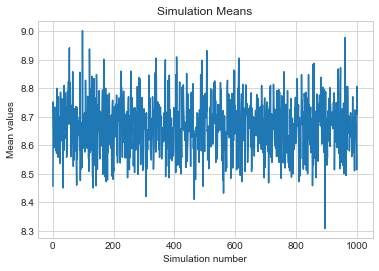

In [43]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

#fig = plt.figure()
#ax = plt.axes()

x = np.arange(1, num_simulations+1, dtype=int)
#plt.plot(x, mean_list);
ax = plt.axes()
ax.plot(x, mean_list)
ax.set(xlabel='Simulation number', ylabel='Mean values',
       title='Simulation Means');

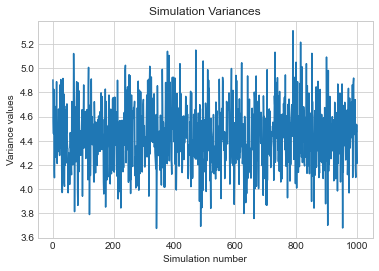

In [45]:
ax = plt.axes()
ax.plot(x, var_list)
ax.set(xlabel='Simulation number', ylabel='Variance values',
       title='Simulation Variances');


In [18]:
dice_target_values = [ 1, 2, 3, 4, 5, 6 ]

sum_vals = np.sum( dice_target_values )

dice_target_prob = [ 1/sum_vals, 2/sum_vals, 3/sum_vals, 4/sum_vals, 5/sum_vals, 6/sum_vals ]

dice_target_prob


[0.047619047619047616,
 0.09523809523809523,
 0.14285714285714285,
 0.19047619047619047,
 0.23809523809523808,
 0.2857142857142857]

In [19]:
np.sum(dice_target_prob)

0.9999999999999999

In [24]:
np.arange(1, 11, dtype=int)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])